# Experiment: Loss Curves
Plot train/eval loss curves for each stage from saved training logs.
Supports both `train_loss_split*.csv` and `train_logs_split*.pkl` sources.


In [17]:
from pathlib import Path
import pickle
import re

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display

repo_root = Path.cwd()
if not (repo_root / "scripts").exists() and (repo_root.parent / "scripts").exists():
    repo_root = repo_root.parent


def _split_id_from_path(path: Path) -> int:
    m = re.search(r"split(\d+)", path.stem)
    if not m:
        raise ValueError(f"cannot parse split id from: {path}")
    return int(m.group(1))


def _flatten_logs(split_id: int, train_logs: dict) -> pd.DataFrame:
    records: list[dict] = []
    for stage_name, payload in train_logs.items():
        if stage_name in {"split_id", "train_mode"}:
            continue
        if not isinstance(payload, dict):
            continue

        if "epochs" in payload and isinstance(payload["epochs"], list):
            for epoch, item in enumerate(payload["epochs"], start=1):
                if isinstance(item, dict):
                    rec = {"split_id": split_id, "stage": stage_name, "epoch": epoch}
                    rec.update(item)
                    records.append(rec)
            continue

        for sub_stage in ("stage2", "stage3"):
            if sub_stage in payload and isinstance(payload[sub_stage], list):
                for epoch, item in enumerate(payload[sub_stage], start=1):
                    if isinstance(item, dict):
                        rec = {
                            "split_id": split_id,
                            "stage": f"{stage_name}.{sub_stage}",
                            "epoch": epoch,
                        }
                        rec.update(item)
                        records.append(rec)

    if not records:
        return pd.DataFrame()
    return pd.DataFrame(records)


def _load_split_loss_df(dataset_dir: Path) -> pd.DataFrame:
    csv_files = sorted(dataset_dir.glob("train_loss_split*.csv"))
    if csv_files:
        frames = [pd.read_csv(f) for f in csv_files]
        return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

    pkl_files = sorted(dataset_dir.glob("train_logs_split*.pkl"))
    if not pkl_files:
        return pd.DataFrame()

    frames: list[pd.DataFrame] = []
    for f in pkl_files:
        with f.open("rb") as handle:
            logs = pickle.load(handle)
        split_id = logs.get("split_id", _split_id_from_path(f))
        df = _flatten_logs(split_id, logs)
        if not df.empty:
            frames.append(df)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()


def _pick_train_col(stage_df: pd.DataFrame) -> str | None:
    for col in ("loss", "total", "scpram_loss", "recon", "kl"):
        if col in stage_df.columns and stage_df[col].notna().any():
            return col
    return None


def plot_loss_curves(dataset: str, results_root: Path, out_dir: Path | None = None) -> Path:
    dataset_dir = results_root / dataset
    if not dataset_dir.exists():
        raise FileNotFoundError(f"dataset results dir not found: {dataset_dir}")

    df = _load_split_loss_df(dataset_dir)
    if df.empty:
        raise FileNotFoundError(
            f"no training logs found in {dataset_dir} (need train_loss_split*.csv or train_logs_split*.pkl)"
        )

    if out_dir is None:
        out_dir = dataset_dir / "loss_plots"
    out_dir.mkdir(parents=True, exist_ok=True)

    merged_csv = out_dir / "all_loss_records.csv"
    df.to_csv(merged_csv, index=False)

    generated = []
    for split_id in sorted(df["split_id"].dropna().unique()):
        split_df = df[df["split_id"] == split_id].copy()
        for stage in sorted(split_df["stage"].dropna().unique()):
            stage_df = split_df[split_df["stage"] == stage].sort_values("epoch")
            train_col = _pick_train_col(stage_df)
            has_val = "val_loss" in stage_df.columns and stage_df["val_loss"].notna().any()
            if train_col is None and not has_val:
                continue

            plt.figure(figsize=(8, 5))
            if train_col is not None:
                plt.plot(stage_df["epoch"], stage_df[train_col], label=f"train ({train_col})")
            if has_val:
                plt.plot(stage_df["epoch"], stage_df["val_loss"], label="eval (val_loss)")
            plt.xlabel("epoch")
            plt.ylabel("loss")
            plt.title(f"{dataset} split{int(split_id)} {stage}")
            plt.grid(True, alpha=0.3)
            plt.legend()
            safe_stage = str(stage).replace(".", "_")
            out_path = out_dir / f"split{int(split_id)}_{safe_stage}_loss.png"
            plt.tight_layout()
            plt.savefig(out_path, dpi=150)
            plt.close()
            generated.append(out_path)

    print(f"[loss_plot] merged records: {merged_csv}")
    print(f"[loss_plot] generated png files: {len(generated)}")
    for f in generated:
        print(f"[loss_plot] {f}")
    return out_dir


In [18]:
# Configuration
dataset = "adamson"
results_root = repo_root / "artifacts" / "results"
out_dir = None  # e.g. repo_root / "artifacts" / "results" / dataset / "loss_plots"


In [19]:
out_path = plot_loss_curves(dataset=dataset, results_root=results_root, out_dir=out_dir)
print("Output dir:", out_path)
        


[loss_plot] merged records: e:\CODE\trishift\artifacts\results\adamson\loss_plots\all_loss_records.csv
[loss_plot] generated png files: 10
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split1_stage1_loss.png
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split1_stage23_joint_loss.png
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split2_stage1_loss.png
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split2_stage23_joint_loss.png
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split3_stage1_loss.png
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split3_stage23_joint_loss.png
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split4_stage1_loss.png
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split4_stage23_joint_loss.png
[loss_plot] e:\CODE\trishift\artifacts\results\adamson\loss_plots\split5_stage1_loss.png
[loss_plot] e:\CODE\trishift\art

PNG count: 10
Display: split1_stage1_loss.png


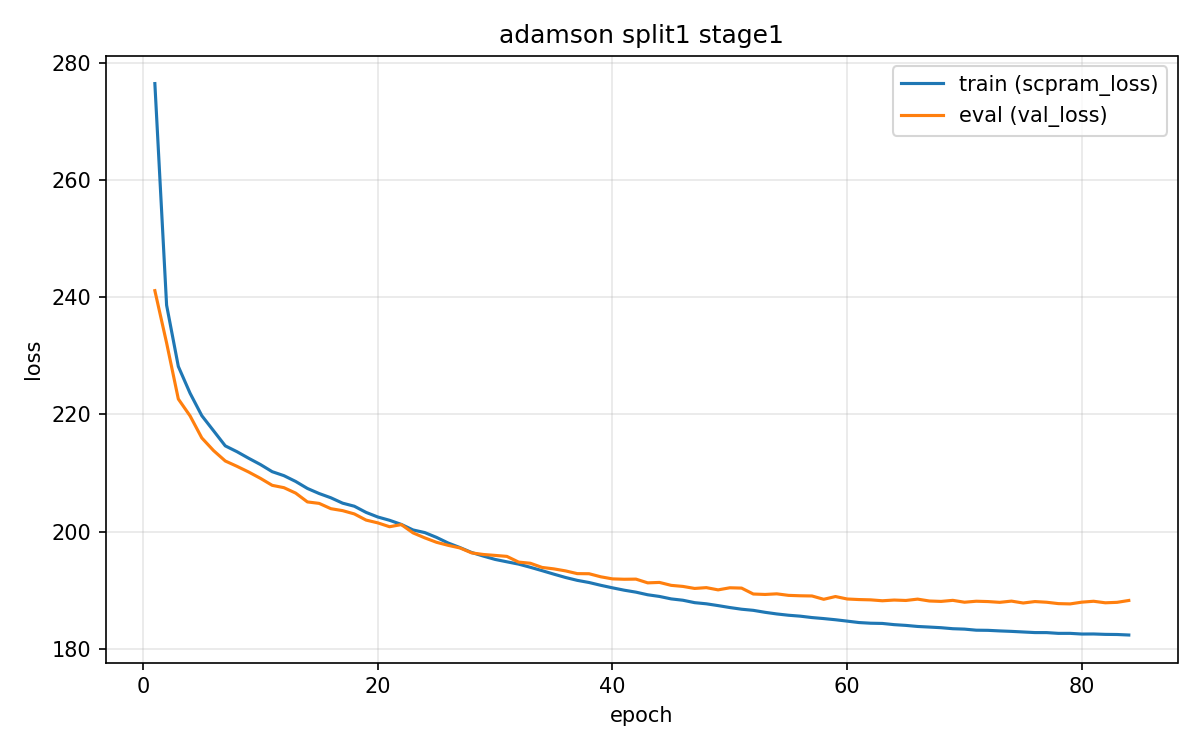

Display: split1_stage23_joint_loss.png


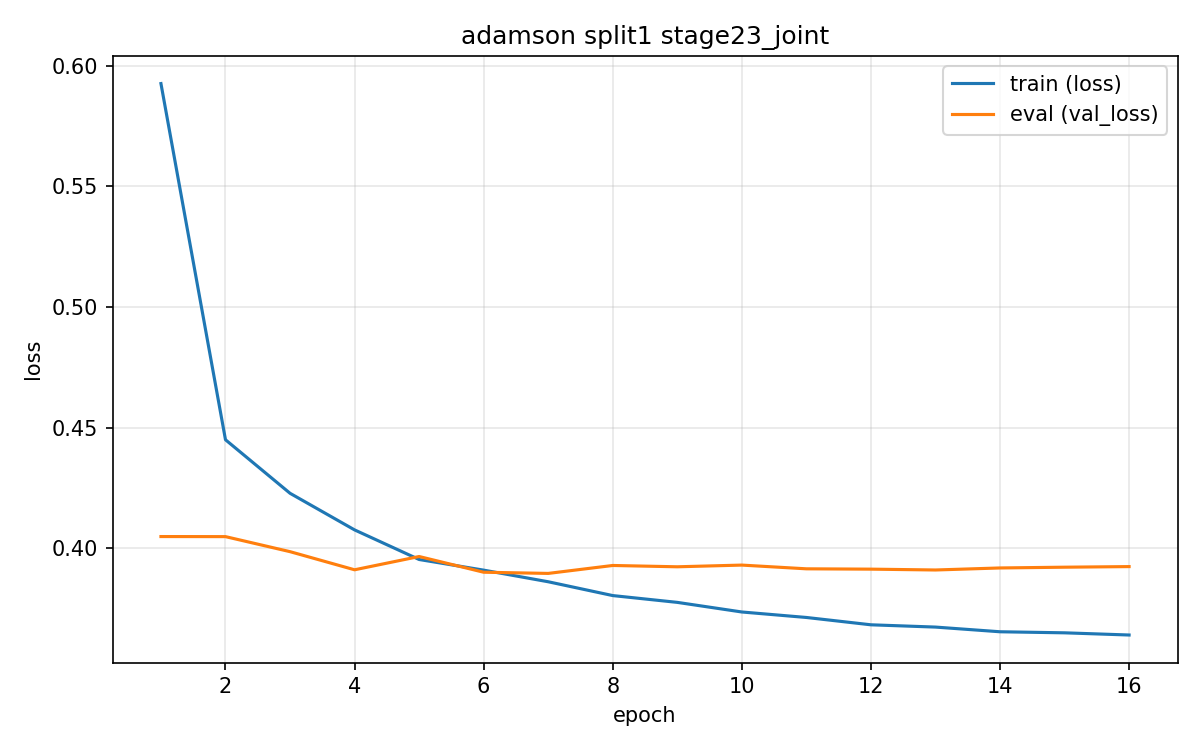

Display: split2_stage1_loss.png


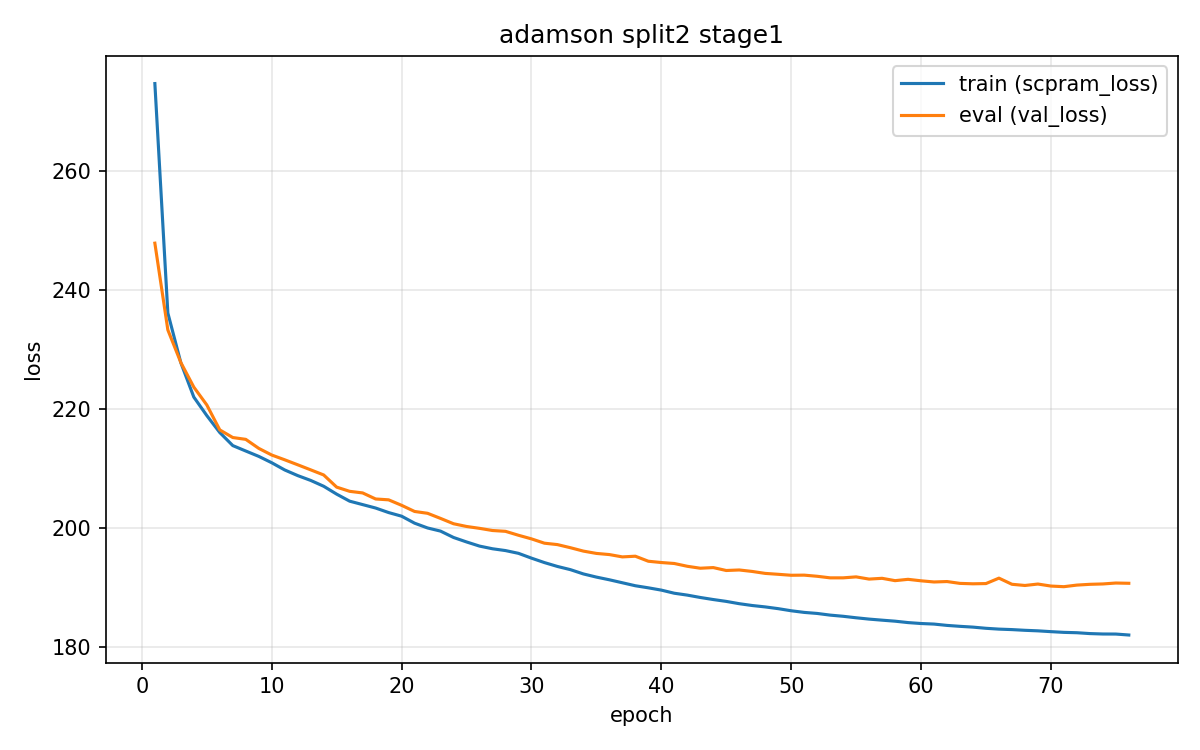

Display: split2_stage23_joint_loss.png


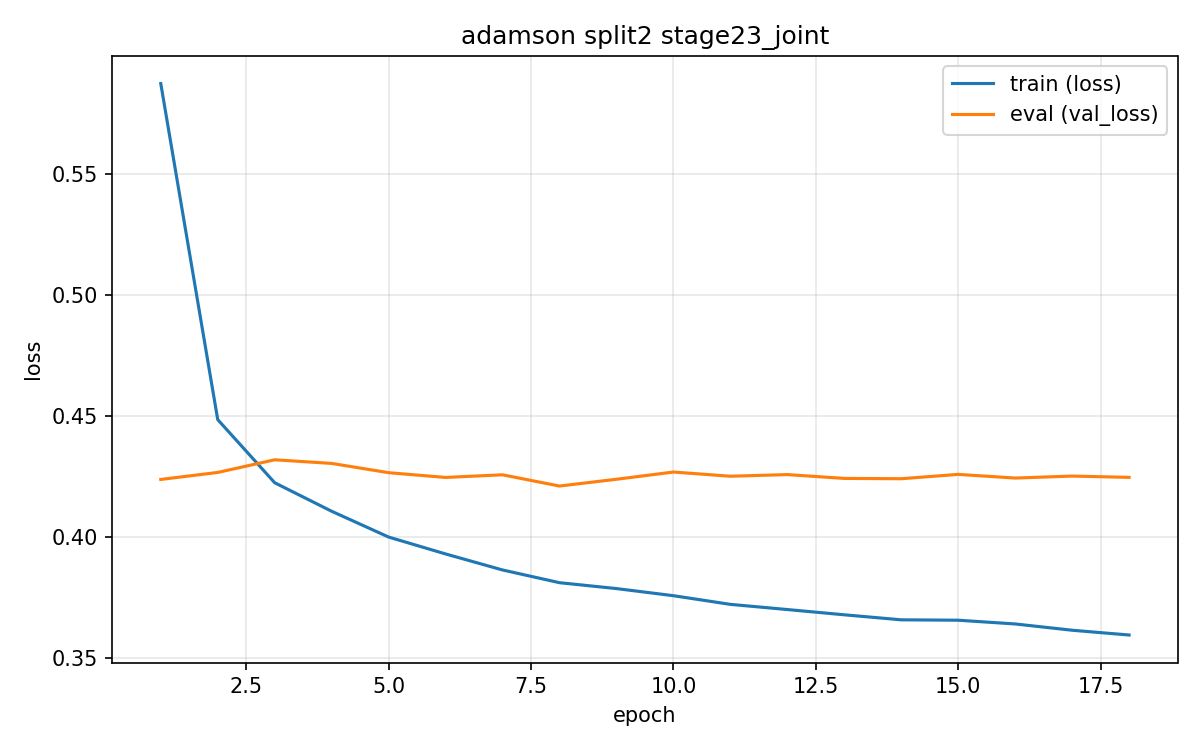

Display: split3_stage1_loss.png


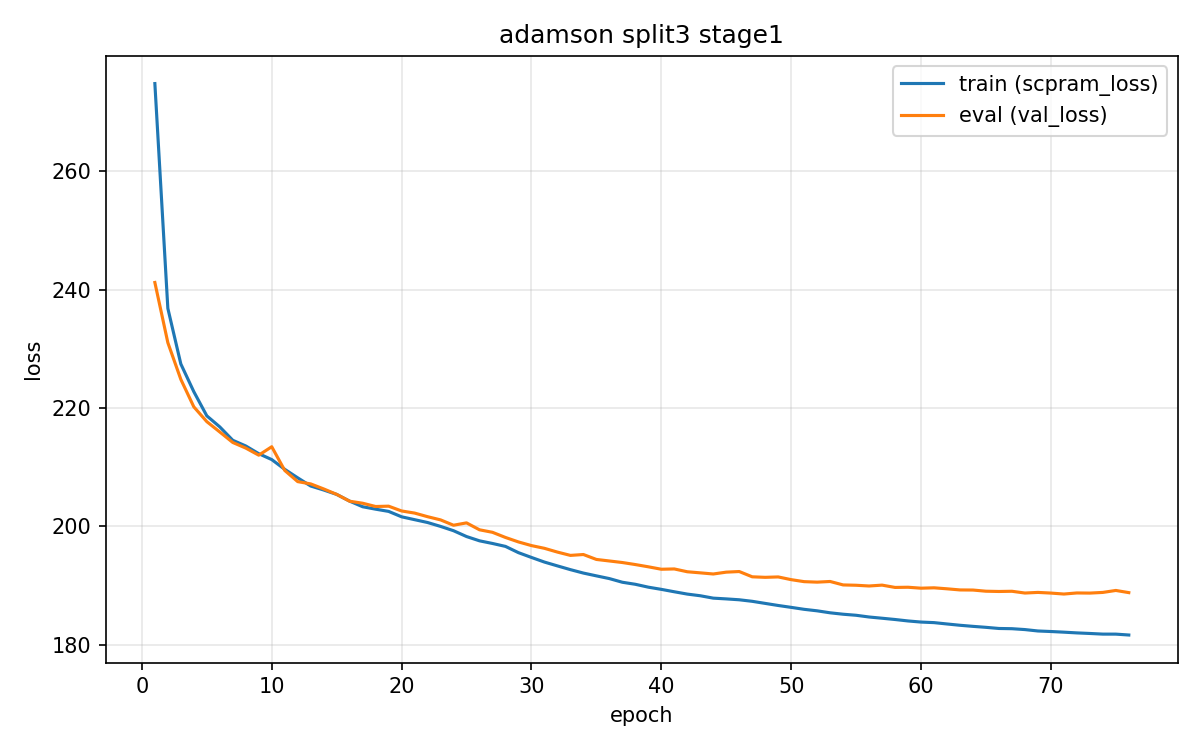

Display: split3_stage23_joint_loss.png


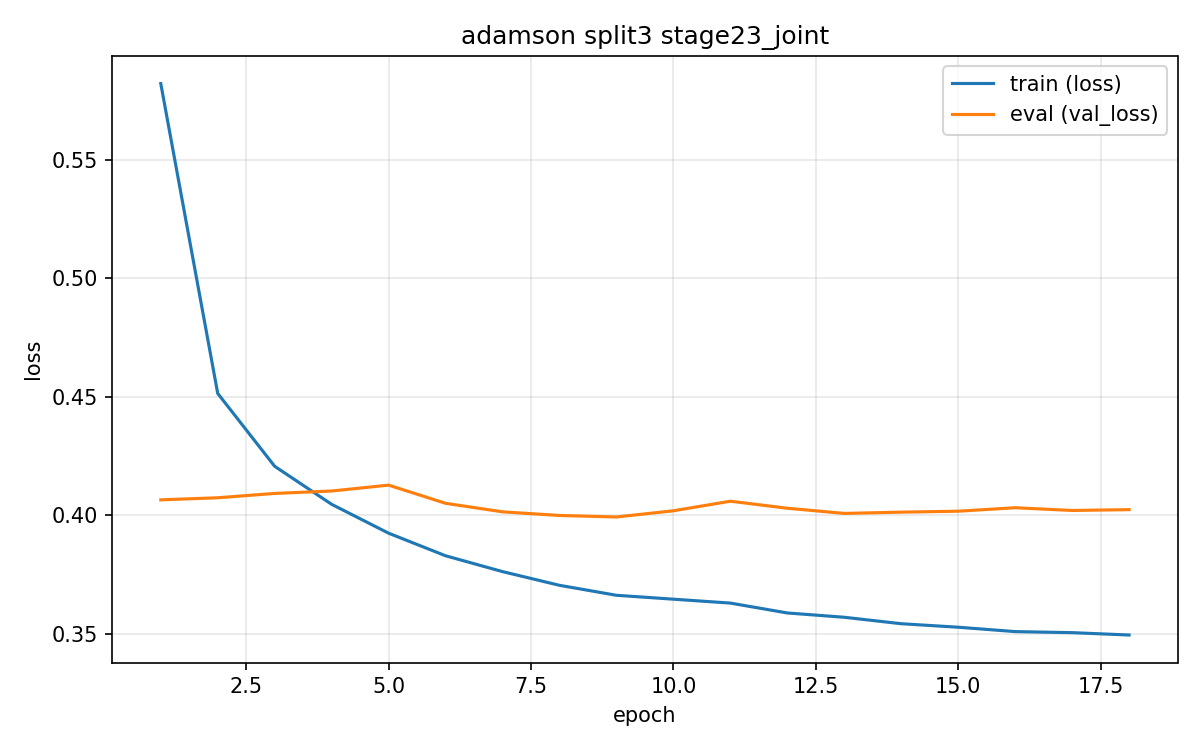

Display: split4_stage1_loss.png


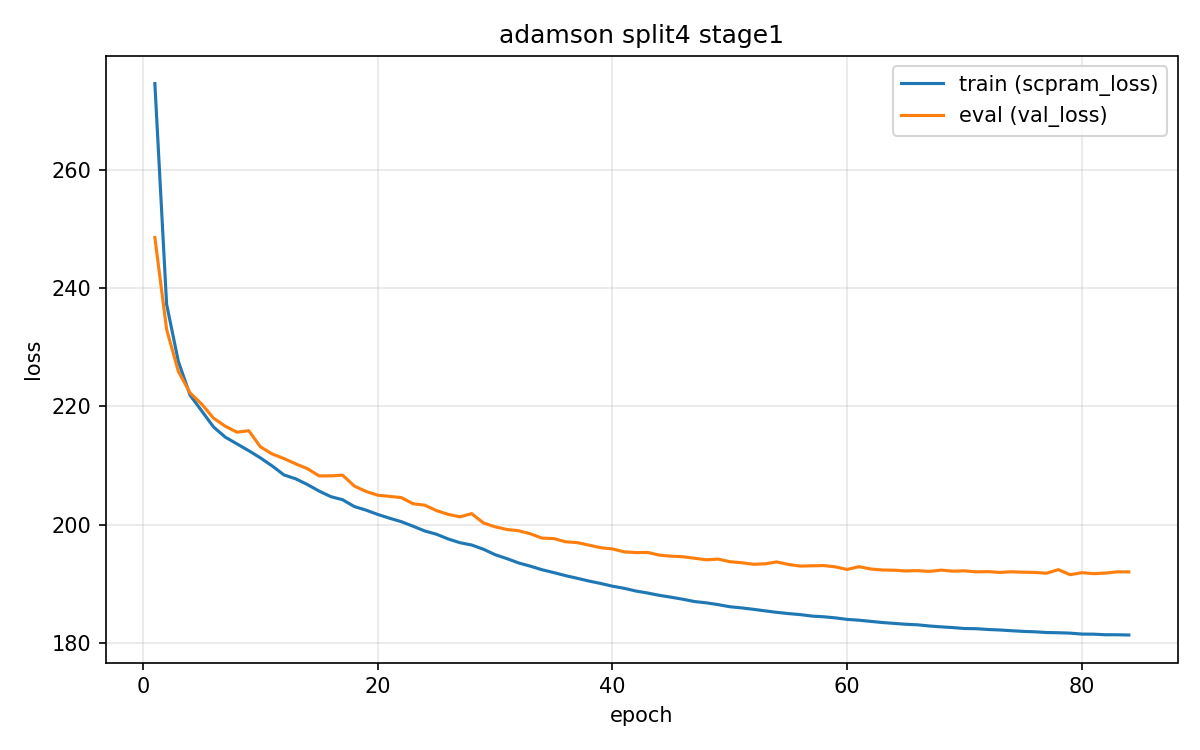

Display: split4_stage23_joint_loss.png


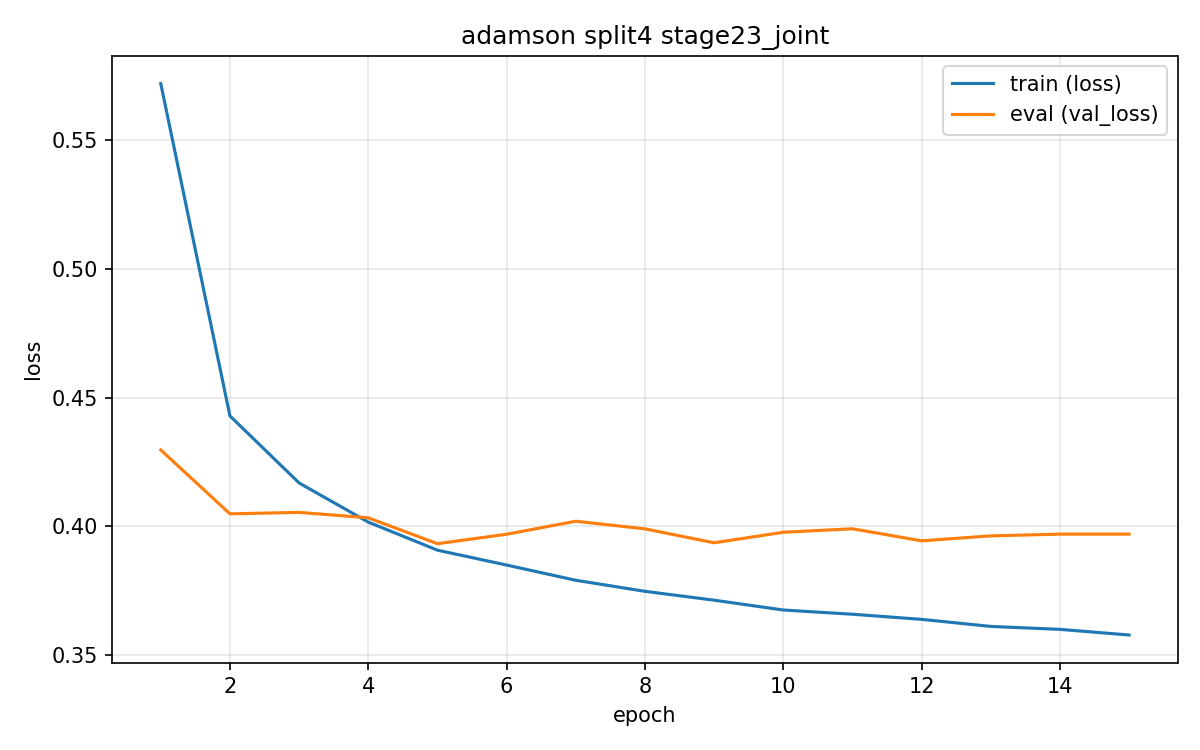

Display: split5_stage1_loss.png


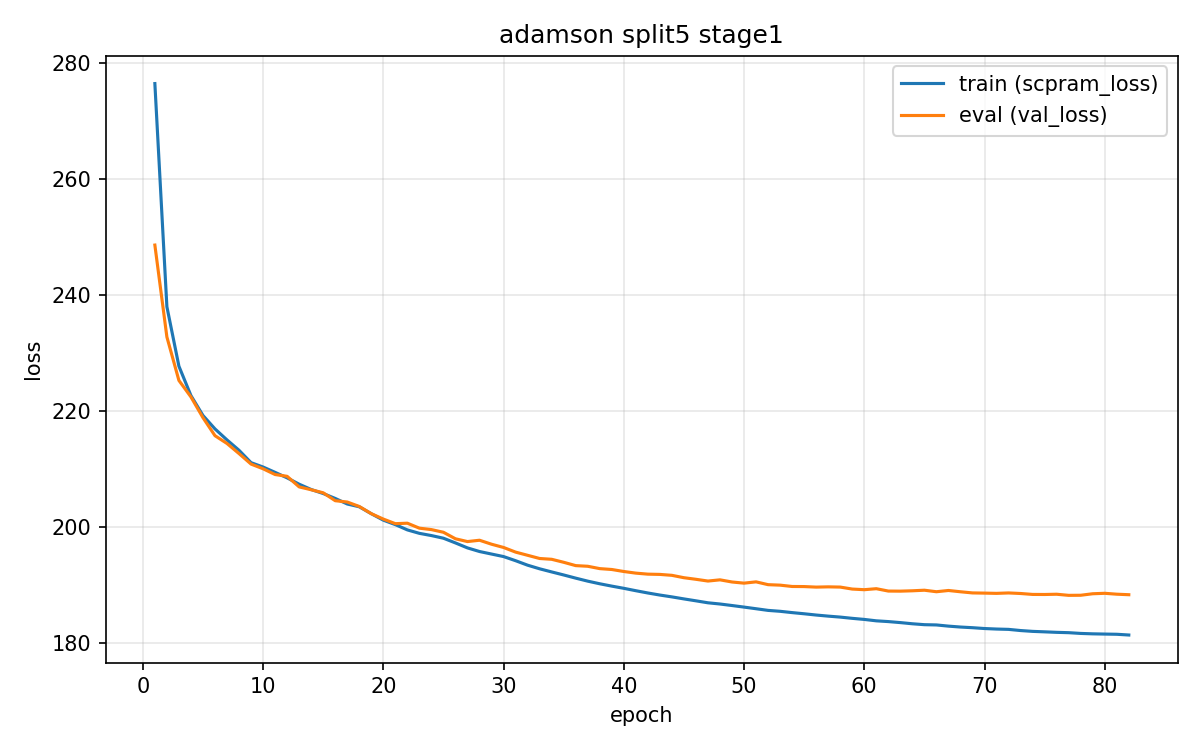

Display: split5_stage23_joint_loss.png


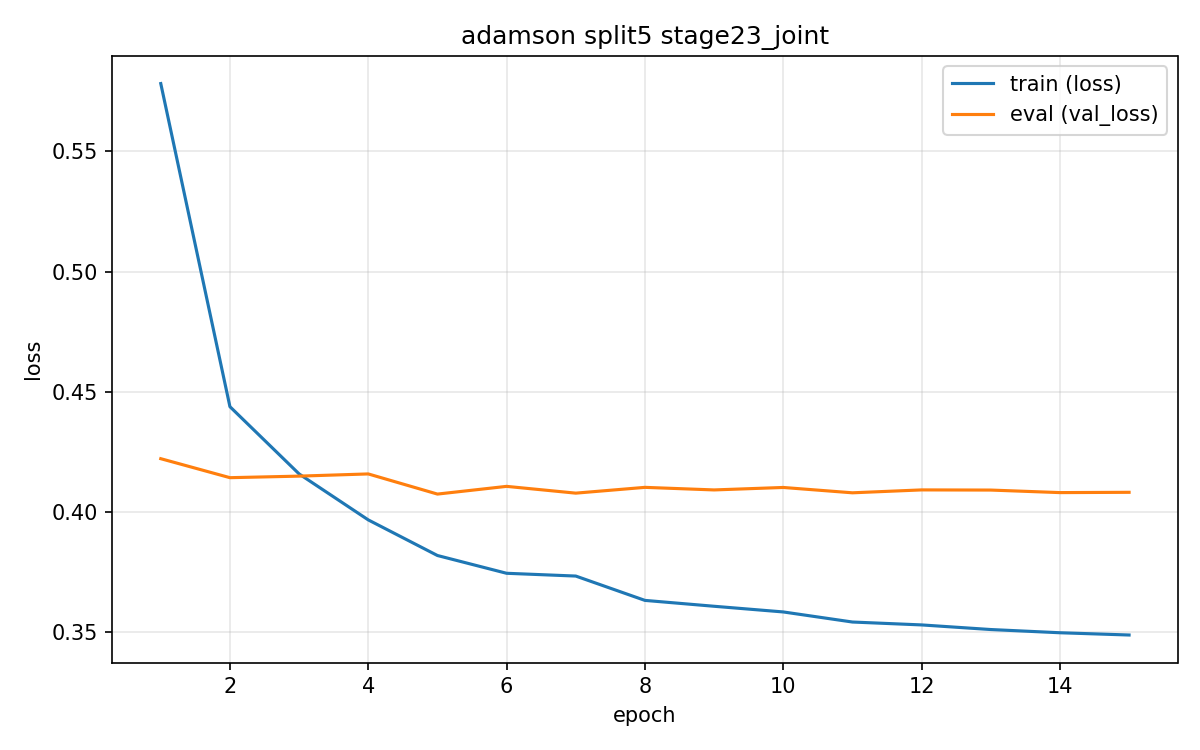

In [20]:
png_files = sorted(out_path.glob("*.png"))
print(f"PNG count: {len(png_files)}")
if not png_files:
    raise FileNotFoundError(f"No PNG files found in {out_path}")

for p in png_files:
    print("Display:", p.name)
    display(Image(filename=str(p)))
        
